In [1]:
from glob import glob
import pandas as pd
import numpy as np
# from omegaconf import OmegaConf
from tqdm import tqdm
# import logging
# logger = logging.getLogger(__name__)

In [2]:
logdirs = [
    "logs/exp1",
    "logs/exp2",
    "logs/exp3",
    # "logs/exp1b",
    # "logs/fix2_exp2",
    # "logs/fix3_exp2",
    # "logs/exp4",
    # "logs/exp5",
]
# logdirs = ["logs/exp4"]

In [3]:
def extract_results(logdir: str) -> dict:
    files = glob("**/srf_estimates.csv", root_dir=logdir, recursive=True)
    print(f"Extracting {len(files)} files that look like {files[0]}")

    results = []

    for f in tqdm(files):
        try:
            comps = f.replace("/", "_").split("_")
            # family, seed, dataset, arch, strategy, backbone, *_ = comps
            dataset, family, strategy, backbone, arch, seed, *_ = comps
            expid = "_".join(comps[:-1])

            # config file
            # conf_file = f.replace("srf_estimates.csv", ".hydra/config.yaml")
            # conf = OmegaConf.load(logdir + "/" + conf_file)

            # read pandas
            df = pd.read_csv(logdir + "/" + f)
            df["dataset"] = dataset
            df["family"] = family + "_" + arch + "_" + backbone
            df["seed"] = seed
            df["experiment"] = strategy
            df["arch"] = arch
            df["backbone"] = backbone
            df["expid"] = expid
            df["setup"] = dataset + "_" + family
            df["f"] = f
            df["shiftid"] = np.arange(df.shape[0])
            results.append(df)
        except:
            continue

    results = pd.concat(results)

    # obtain mse, variance, bias2 metrics
    error_metrics = results.groupby(
        ["dataset", "family", "experiment", "shiftid"]
    ).apply(_compute_metrics)
    error_metrics = (
        error_metrics.reset_index().groupby(["dataset", "family", "experiment"]).median()
    ).drop(columns=["shiftid"])

    # rank by seed too. Ranks are compute from the average mse along the curve
    curve_train_err = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "train_err"})
    )
    curve_test_err = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "test_err"})
    )
    curve_train_err["train_rank"] = (
        curve_train_err.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .train_err
    )
    curve_test_err["test_rank"] = (
        curve_test_err.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .test_err
    )
    ranks = curve_train_err.merge(
        curve_test_err, on=["dataset", "family", "seed", "experiment"]
    )

    return dict(
        results=results,
        metrics=error_metrics,
        ranks=ranks,
        # roc=roc,
        # auc=auc,
    )


def _compute_metrics(x: pd.DataFrame) -> pd.Series:
    C_train = 1 # np.abs(x["true_train_srf"].iloc[0] + 1e-2)
    C_test = 1 # np.abs(x["true_test_srf"].iloc[0] + 1e-2)
    out = dict(
        train_err=np.abs(x["train_srf"] - x["true_train_srf"]).sum() / C_train,
        test_err=np.abs(x["test_srf"] - x["true_test_srf"]).sum() / C_test,
        n=x.shape[0],
        # train_bias2=(x["train_srf"].mean() - x["true_train_srf"].mean()) ** 2,
        # test_bias2=(x["test_srf"].mean() - x["true_test_srf"].mean()) ** 2,
        # train_variance=x["train_srf"].var(),
        # test_variance=x["test_srf"].var(),
    )
    return pd.Series(out.values(), index=out.keys())

In [4]:
results_ = []
for logdir in logdirs:
    print(f"Extracting results from {logdir}")
    results_.append(extract_results(logdir))
keys = list(results_[0].keys())

# append dataframes of elements of results
results = results_[0]
for other_results in results_[1:]:
    for key in keys:
        results[key] = pd.concat([results[key], other_results[key]])

results["metrics"] = (
    results["metrics"]
    .reset_index()
    .sort_values(["dataset", "family", "train_err"], ascending=False)
)

Extracting results from logs/exp1
Extracting 13824 files that look like news_gaussian/tresnet-clever-telescope_vc_large/37/srf_estimates.csv


100%|██████████| 13824/13824 [01:13<00:00, 187.92it/s]


Extracting results from logs/exp2
Extracting 8409 files that look like news_gaussian/tresnet-clever_causalmlp_large/37/srf_estimates.csv


100%|██████████| 8409/8409 [00:28<00:00, 295.18it/s]


Extracting results from logs/exp3
Extracting 6144 files that look like ihdp_poisson/outcome_vc_large/37/srf_estimates.csv


100%|██████████| 6144/6144 [00:20<00:00, 294.60it/s]


In [12]:
results["results"].to_csv("results.csv", index=False)

In [13]:
r = results["results"].head()

KeyboardInterrupt: 

In [5]:
# remove row limits
pd.set_option("display.max_rows", None, "display.max_columns", None)
results["metrics"].set_index(["dataset", "family", "experiment"])

train_err  \
dataset family                   experiment                               
tcga-3  poisson_large_vc         outcome-forcemse          1.380934e+06   
                                 tresnet-clever-forcemse   8.197980e+05   
                                 outcome                   1.242217e+03   
                                 tresnet-clever            7.304206e+02   
        gaussian_large_vc        aipw                      6.019385e+02   
                                 tmle-clever               5.418616e+02   
                                 aipw-ps                   7.980418e+01   
                                 ipw-multips               5.247107e+01   
                                 ipw-hybrid                4.049206e+01   
                                 ipw-ps                    3.615609e+01   
                                 outcome                   3.432674e+01   
                                 ipw-classifier            2.751428e+01   
                                 ipw-telescope             1.992119e+01   
                                 vcnet                     1.641771e+01   
                                 tresnet-clever-telescope  1.472098e+01   
                                 tarnet-telescope          1.452260e+01   
                                 tresnet-clever-1          1.236990e+01   
                                 tresnet-clever-splines    1.226474e+01   
                                 tarnet-ps                 1.193186e+01   
                                 tresnet-clever-ps         1.182955e+01   
                                 tarnet                    1.156401e+01   
                                 tresnet-clever            1.152909e+01   
        gaussian_large_piecewise aipw                      1.912167e+02   
                                 outcome                   5.036276e+01   
                                 aipw-ps                   4.049241e+01   
                                 vcnet                     1.655736e+01   
                                 tresnet-clever            9.872090e+00   
                                 tresnet-clever-ps         6.160212e+00   
        gaussian_large_causalmlp aipw                      6.490857e+02   
                                 aipw-ps                   7.152757e+01   
                                 tresnet-clever            3.250741e+01   
                                 outcome                   2.556255e+01   
                                 vcnet                     2.334430e+01   
                                 tresnet-clever-ps         2.198785e+01   
        bernoulli_large_vc       outcome-forcemse          4.581367e+01   
                                 tresnet-clever-forcemse   4.275555e+01   
                                 outcome                   3.797632e+01   
                                 tresnet-clever            2.320810e+00   
tcga-2  poisson_large_vc         tresnet-clever-forcemse   1.548395e+06   
                                 outcome-forcemse          5.641679e+05   
                                 tresnet-clever            3.827414e+04   
                                 outcome                   4.748150e+03   
        gaussian_large_vc        aipw                      6.945515e+02   
                                 tmle-clever               6.152354e+02   
                                 aipw-ps                   7.273273e+01   
                                 outcome                   2.417286e+01   
                                 vcnet                     1.844932e+01   
                                 tresnet-clever-1          1.664001e+01   
                                 tresnet-clever-splines    1.614163e+01   
                                 tarnet                    1.597363e+01   
                                 tresnet-clever-telescope  1.497704e+01   
                                 tresnet-clever            1.463304e+01   
            

In [6]:
# (
#     results["ranks"]
#     .groupby(["family", "dataset", "experiment"])
#     .mean()
#     .drop(columns=["seed"])
# )

In [7]:
r = results["results"]
ecols = [ "family", "dataset", "seed"]
r["train_error"] = r["train_srf"] - r["true_train_srf"]
r["test_error"] = r["test_srf"] - r["true_test_srf"]
# m1 = "ipw-classifier" # "tresnet-clever-ps"
# m2 = "ipw-ps" # "vcnet"
m1 = "tresnet-clever"
m2 = "vcnet"
df1 = r[r.experiment == m1][["train_error", "test_error", "shiftid"] + ecols]
df2 = r[r.experiment == m2][["train_error", "test_error", "shiftid"] + ecols]
dfd = pd.merge(df1, df2, on=["shiftid"] + ecols, suffixes=["_1", "_2"])
dfd["train_err_diff"] = dfd["train_error_1"].abs() - dfd["train_error_2"].abs()
dfd["test_err_diff"] = dfd["test_error_1"].abs() - dfd["test_error_2"].abs()
dfd = dfd.drop(columns=["train_error_1", "train_error_2", "test_error_1", "test_error_2"])
dfd["shiftid"] = dfd["shiftid"].astype(int)
# dfd.head()

In [8]:
# compute mean and standard errors
# for standard errors must use 1.96 * std / sqrt(n)
def lci95(x):
    return x.mean() - 1.96 * x.std() / np.sqrt(len(x))
def uci95(x):
    return x.mean() + 1.96 * x.std() / np.sqrt(len(x))
def iqr75(x):
    return x.quantile(0.75)
def iqr25(x):
    return x.quantile(0.25)

dfd.drop(columns=["seed", "shiftid"]).groupby(["family", "dataset"]).agg(["mean", "std", lci95, uci95])
# dfd.drop(columns=["seed", "shiftid"]).groupby(["family", "dataset"]).agg(["median", iqr25, iqr75])

train_err_diff                                \
                                           mean       std     lci95     uci95   
family                   dataset                                                
gaussian_large_causalmlp ihdp          0.022463  0.065730  0.018305  0.026621   
                         ihdp-B        0.022345  0.082354  0.017135  0.027554   
                         news         -0.017705  0.181903 -0.029212 -0.006198   
                         sim-B        -0.008897  0.064539 -0.012980 -0.004815   
                         sim-N        -0.015479  0.046110 -0.018396 -0.012563   
                         tcga-1       -0.060454  0.169308 -0.071164 -0.049744   
                         tcga-2       -0.011692  0.057256 -0.015314 -0.008070   
                         tcga-3        0.080984  0.113417  0.073809  0.088158   
gaussian_large_piecewise ihdp         -0.038342  0.174992 -0.049412 -0.027273   
                         ihdp-B       -0.156735  0.268225 -0.173703 -0.139768   
                         news         -0.049410  0.214946 -0.063008 -0.035813   
                         sim-B        -0.032518  0.132553 -0.040903 -0.024133   
                         sim-N        -0.030032  0.102985 -0.036547 -0.023518   
                         tcga-1        0.041807  0.213578  0.028297  0.055318   
                         tcga-2        0.013253  0.153128  0.003566  0.022940   
                         tcga-3       -0.063189  0.128040 -0.071289 -0.055089   
gaussian_large_vc        ihdp          0.023710  0.199627  0.011082  0.036338   
                         ihdp-B       -0.071905  0.230290 -0.086473 -0.057337   
                         news         -0.084765  0.194441 -0.097065 -0.072465   
                         sim-B        -0.049160  0.155279 -0.058982 -0.039337   
                         sim-N        -0.037976  0.121301 -0.045650 -0.030303   
                         tcga-1       -0.008017  0.249365 -0.023792  0.007757   
                         tcga-2       -0.048194  0.205980 -0.061224 -0.035164   
                         tcga-3       -0.045556  0.130154 -0.053789 -0.037323   

                                 test_err_diff                                
                                          mean       std     lci95     uci95  
family                   dataset                                              
gaussian_large_causalmlp ihdp        -0.273936  0.484416 -0.304580 -0.243293  
                         ihdp-B      -1.231993  1.455878 -1.324090 -1.139896  
                         news        -5.054168  3.961485 -5.304767 -4.803570  
                         sim-B       -0.254853  0.597464 -0.292648 -0.217058  
                         sim-N       -0.137935  0.612836 -0.176702 -0.099168  
                         tcga-1      -0.051530  0.263434 -0.068194 -0.034865  
                         tcga-2      -0.082054  0.178489 -0.093345 -0.070763  
                         tcga-3      -0.435688  0.578694 -0.472295 -0.399080  
gaussian_large_piecewise ihdp        -0.539607  0.591051 -0.576996 -0.502218  
                         ihdp-B      -1.086973  1.202205 -1.163023 -1.010923  
                         news        -4.005571  3.596537 -4.233083 -3.778058  
                         sim-B       -0.076967  0.262546 -0.093575 -0.060359  
                         sim-N       -0.130271  0.429887 -0.157465 -0.103077  
                         tcga-1       0.034662  0.343321  0.012944  0.056380  
                         tcga-2      -0.059574  0.235889 -0.074496 -0.044652  
                         tcga-3      -0.693217  0.615990 -0.732184 -0.654250  
gaussian_large_vc        ihdp        -0.054904  0.405763 -0.080572 -0.029236  
                         ihdp-B      -0.093941  0.936126 -0.153159 -0.034722  
                         news        -4.038827  3.209285 -4.241842 -3.835811  
                         sim-B       -0.089754  0.293699 -0.108333 -0.071175  
                         sim

In [9]:
dfd.drop(columns=["seed"]).groupby(["family", "dataset", "shiftid"]).agg(["mean", "std"])

train_err_diff            \
                                                   mean       std   
family                   dataset shiftid                            
gaussian_large_causalmlp ihdp    0            -0.000737  0.005382   
                                 1            -0.011625  0.011578   
                                 2            -0.022350  0.017593   
                                 3            -0.032651  0.024272   
                                 4            -0.038916  0.033315   
                                 5             0.003789  0.050034   
                                 6             0.065022  0.045662   
                                 7             0.076183  0.052937   
                                 8             0.087372  0.060328   
                                 9             0.098547  0.067686   
                         ihdp-B  0            -0.005072  0.051673   
                                 1            -0.016140  0.054772   
                                 2            -0.025155  0.057731   
                                 3            -0.033592  0.061348   
                                 4            -0.029814  0.070174   
                                 5             0.036701  0.056628   
                                 6             0.057472  0.052627   
                                 7             0.070215  0.081208   
                                 8             0.079657  0.086943   
                                 9             0.089174  0.092696   
                         news    0            -0.060640  0.072420   
                                 1             0.004699  0.082587   
                                 2             0.038979  0.098438   
                                 3             0.069033  0.113804   
                                 4             0.091250  0.124620   
                                 5             0.092858  0.123104   
                                 6             0.055010  0.136774   
                                 7            -0.051852  0.180898   
                                 8            -0.172182  0.205413   
                                 9            -0.244206  0.234427   
                         sim-B   0            -0.039570  0.032333   
                                 1            -0.021274  0.046886   
                                 2            -0.018386  0.052983   
                                 3            -0.013930  0.056475   
                                 4            -0.010432  0.059658   
                                 5            -0.012033  0.061496   
                                 6            -0.008235  0.067114   
                                 7             0.005529  0.071941   
                                 8             0.014583  0.078039   
                                 9             0.014776  0.084424   
                         sim-N   0            -0.019543  0.016810   
                                 1             0.000531  0.026245   
                                 2             0.007707  0.028206   
                                 3             0.013924  0.028886   
                                 4             0.014812  0.034823   
                                 5            -0.003424  0.042463   
                                 6            -0.028568  0.045749   
                                 7            -0.041307  0.046265   
                                 8            -0.046844  0.050818   
                                 9            -0.052082  0.055391   
                         tcga-1  0            -0.033888  0.153794   
                                 1            -0.029365  0.137962   
                                 2            -0.033293  0.124496   
                                 3            -0.041586  0.122106   
                                 4            -0.055998  0.127240   
                                 5     

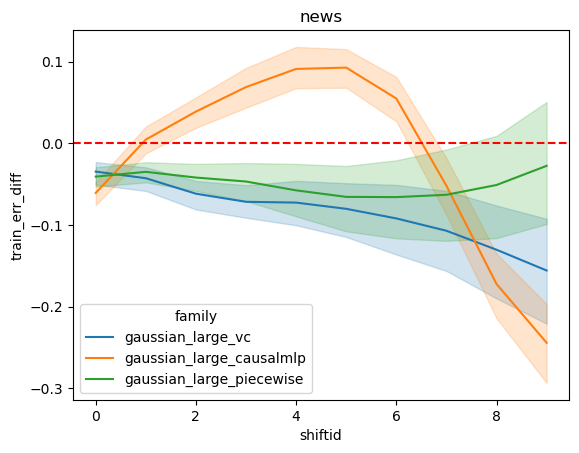

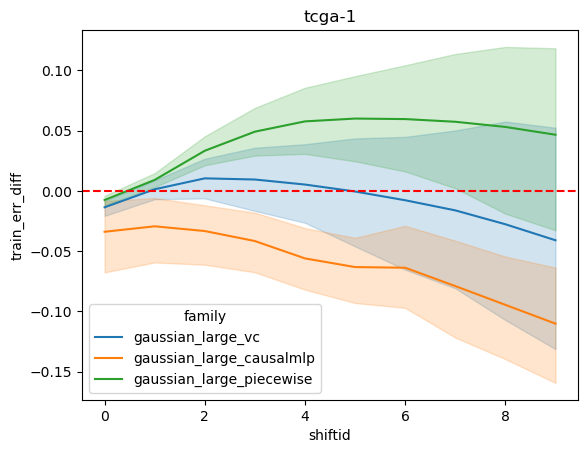

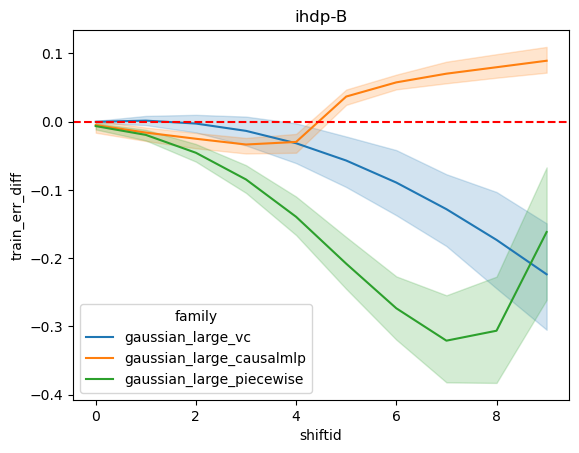

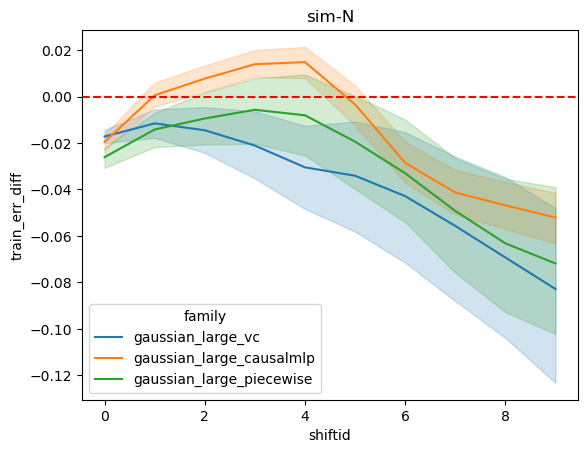

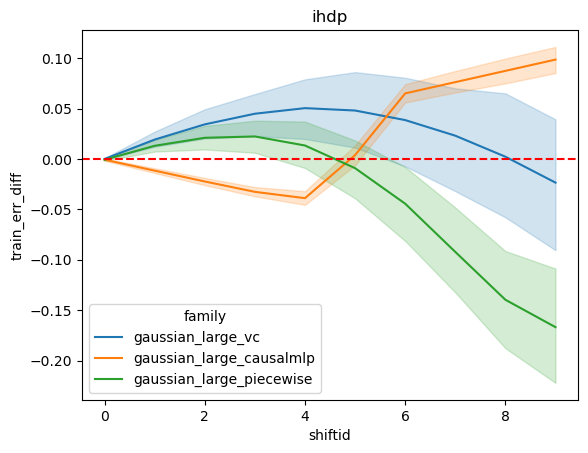

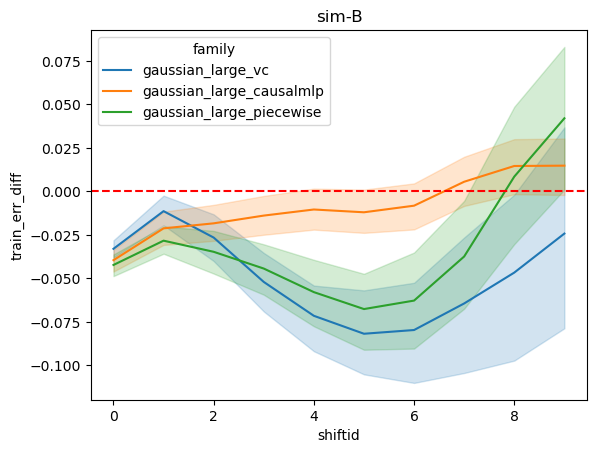

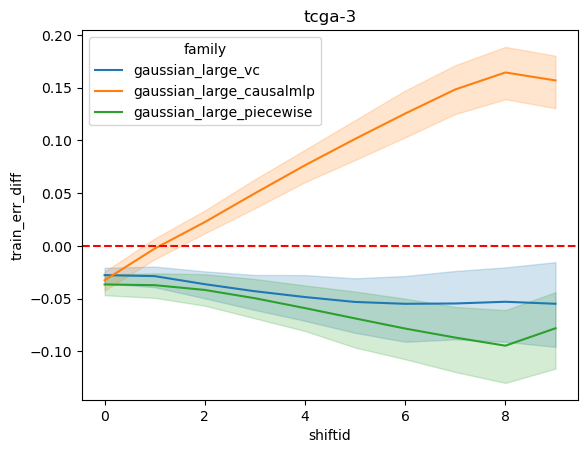

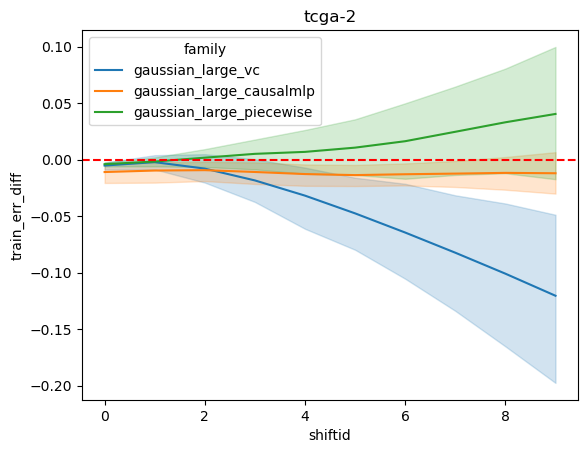

In [10]:
# make shiftid by train_err_diff plot
import seaborn as sns
import matplotlib.pyplot as plt

for d in dfd.dataset.unique():
    sdfd = dfd[dfd.dataset == d]
    f = sns.lineplot(
        data=sdfd,
        x="shiftid",
        y="train_err_diff",
        hue="family",
    )
    # add hline at 0 red dotted
    f.axhline(0, ls='--', color='red')    
    plt.title(d)
    plt.show()

In [11]:
# # make shiftid by train_err_diff plot
# import seaborn as sns
# import matplotlib.pyplot as plt

# for d in dfd.dataset.unique():
#     sdfd = dfd[dfd.dataset == d]
#     sns.lineplot(
#         data=sdfd,
#         x="shiftid",
#         y="test_err_diff",
#         hue="family",
#     )
#     plt.title(d)
#     plt.show()